[src](http://scikit-learn.org/stable/auto_examples/semi_supervised/plot_label_propagation_digits_active_learning.html#sphx-glr-auto-examples-semi-supervised-plot-label-propagation-digits-active-learning-py)

### demonstration of active learning via entropy
* doesn't need label_propagation as the learner, can very well use any supervised methods!!!

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]

In [4]:
n_total_samples = len(y)
n_labeled_points = 10
max_iterations = 5

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]

Iteration 0 ______________________________________________________________________
Label Spreading model: 185 labeled & 145 unlabeled (330 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        15
          1       1.00      1.00      1.00        10
          2       1.00      1.00      1.00        20
          3       1.00      1.00      1.00         9
          4       1.00      1.00      1.00        17
          5       1.00      1.00      1.00        16
          6       1.00      1.00      1.00        32
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00         6
          9       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00       145

Confusion matrix
[[15  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 20  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0 17  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0]


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:60: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Iteration 1 ______________________________________________________________________
Label Spreading model: 190 labeled & 140 unlabeled (330 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        15
          1       1.00      1.00      1.00        10
          2       1.00      1.00      1.00        19
          3       1.00      1.00      1.00         8
          4       1.00      1.00      1.00        15
          5       1.00      1.00      1.00        15
          6       1.00      1.00      1.00        32
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00         6
          9       1.00      1.00      1.00         4

avg / total       1.00      1.00      1.00       140

Confusion matrix
[[15  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  0  0  0  0  0  0]
 [ 0  0 19  0  0  0  0  0  0  0]
 [ 0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0]


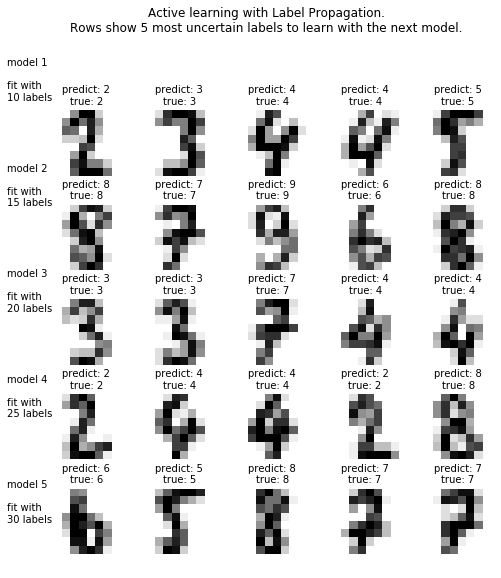

In [12]:
f = plt.figure(figsize=(8, 8))

for i in range(max_iterations):
    if len(unlabeled_indices) == 0:
        print("No unlabeled items left to label.")
        break
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1

    lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
    lp_model.fit(X, y_train)

    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]

    cm = confusion_matrix(true_labels, predicted_labels,
                          labels=lp_model.classes_)

    print("Iteration %i %s" % (i, 70 * "_"))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))

    print("Confusion matrix")
    print(cm)

    # compute the entropies of transduced label distributions
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)

    # select up to 5 digit examples that the classifier is most uncertain about
    uncertainty_index = np.argsort(pred_entropies)[::-1]
    uncertainty_index = uncertainty_index[
        np.in1d(uncertainty_index, unlabeled_indices)][:5]

    # keep track of indices that we get labels for
    delete_indices = np.array([])

    # for more than 5 iterations, visualize the gain only on the first 5
    if i < 5:
        f.text(.05, (1 - (i + 1) * .183),
               "model %d\n\nfit with\n%d labels" %
               ((i + 1), i * 5 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]

        # for more than 5 iterations, visualize the gain only on the first 5
        if i < 5:
            sub = f.add_subplot(5, 5, index + 1 + (5 * i))
            sub.imshow(image, cmap=plt.cm.gray_r)
            sub.set_title("predict: %i\ntrue: %i" % (
                lp_model.transduction_[image_index], y[image_index]), size=10)
            sub.axis('off')

        # labeling 5 points, remote from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))

    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += len(uncertainty_index)

f.suptitle("Active learning with Label Propagation.\nRows show 5 most "
           "uncertain labels to learn with the next model.")
plt.subplots_adjust(0.12, 0.03, 0.9, 0.8, 0.2, 0.45)
plt.show()